In [1]:
pwd

'/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins/Hopkins Academics/Classes/Machine Learning-Deep Learning/Final Project/Scripts/Ensemble'

In [11]:
import sys
print(sys.version)
print(np.__version__)


3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]
1.24.3


In [8]:
pip freeze

absl-py==2.0.0
aiobotocore @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_71xswk40o_/croot/aiobotocore_1682537536268/work
aiofiles @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_f56ag8l7kr/croot/aiofiles_1683773599608/work
aiohttp @ file:///Users/cbousseau/work/recipes/ci_py311/aiohttp_1677926054700/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
aiosqlite @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_3d75lecab1/croot/aiosqlite_1683773918307/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-anon-usage @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_6dviz_3v0e/croot/anaconda-anon-usage_1695305101164/work
anaconda-catalogs @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_e8tmw882qa/croot/anaconda-catalogs_1685727305051/work
anaconda-client==1.12.0


Note: you may need to restart the kernel to use updated packages.


# Imports

In [17]:
import pandas as pd
import numpy as np
import json
import os
import sys
import math
from scipy import stats
import random
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch import nn, optim, Tensor
from torch.autograd import Variable
from torch.utils import model_zoo
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision

from torchvision import datasets, transforms
from torchvision.models.resnet import BasicBlock

from functools import partial
from typing import Any, Callable, List, Optional, Tuple, Sequence
import warnings

import torch
import torch.nn as nn
import torch.nn.init as init

#squeezenet
from torchvision.transforms._presets import ImageClassification
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface

#unique to mobilenet
from torchvision.ops.misc import Conv2dNormActivation
from torchvision.models._utils import _make_divisible

#time functions
import time

#plotting
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize

# Import Custom Model Architecture

In [2]:
add_path = '/Users/starsdliu/Library/CloudStorage/OneDrive-JohnsHopkins' + \
            '/Hopkins Academics/Classes/Machine Learning-Deep Learning/Final Project/Scripts'
sys.path.insert(0, add_path)
#models
from SqueezeNet.snet import *
from MobileNet_V2.mnet import *
from ResNet.rnet import *
from InceptionNet.inet import *

# Additional Functions

In [11]:
# View image
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize if your images were normalized
    img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def plot_performance(train_acc, test_acc, train_loss, test_loss, epochs):

    epochs_range = range(1, epochs + 1)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjust the size as needed
    fig.suptitle('Training and Testing Performance')

    # train acc
    axes[0].plot(epochs_range, train_acc, label='Training Accuracy', marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Training Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # test acc
    axes[1].plot(epochs_range, test_acc, label='Testing Accuracy', color='orange', marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_title('Testing Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # train loss
    axes[2].plot(epochs_range, train_loss, label='Training Loss', marker='o', linestyle='--')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Training Loss')
    axes[2].legend()
    axes[2].grid(True)

    # test loss
    axes[3].plot(epochs_range, test_loss, label='Testing Loss', color='orange', marker='o', linestyle='--')
    axes[3].set_xlabel('Epochs')
    axes[3].set_title('Testing Loss')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Additional Directory Paths Setup

In [9]:
# Base directory where the model directories are located
base_dir = '../'

# Get a list of all subdirectories in the base directory
model_directories = next(os.walk(base_dir))[1]
model_directories = model_directories[1:-1]
print(model_directories)
# Dictionary to store the loaded models
loaded_models = {}

# Loop through each subdirectory and load the model
for model_dir in model_directories:
    # Path to the 'Saved Models' directory
    saved_models_path = os.path.join(base_dir, model_dir, 'savedModels')

    # Check if 'Saved Models' directory exists
    if os.path.isdir(saved_models_path):
        # List all '.pth' files in the 'Saved Models' directory
        model_files = [f for f in os.listdir(saved_models_path) if f.endswith('.pth')]

        if model_files:
            # Load the model (assuming you want the first '.pth' file found)
            model_file_path = os.path.join(saved_models_path, model_files[0])
            loaded_models[model_dir] = torch.load(model_file_path, map_location=torch.device('cpu'))

# Now loaded_models dictionary contains all the loaded models
print(f'There are {len(loaded_models)} models: {", ".join(list(loaded_models.keys()))}.')

['InceptionNet', 'ResNet', 'SqueezeNet', 'MobileNet_V2']
There are 4 models: InceptionNet, ResNet, SqueezeNet, MobileNet_V2.


# GPU Setup

In [10]:
gpu_boole = torch.backends.mps.is_available()
device = torch.device("mps" if gpu_boole else "cpu")
device

device(type='mps')

In [15]:
loaded_models.keys()

dict_keys(['InceptionNet', 'ResNet', 'SqueezeNet', 'MobileNet_V2'])

# Load Models

In [34]:
num_classes = 65

for modelName in loaded_models:
    if modelName == 'SqueezeNet':
        #Initialize
        snet = squeezenet1_0(pretrained = False)
        # Replace the final layer
        snet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        #Load model dictionary
        snet.load_state_dict(loaded_models[modelName])
        #to GPU device
        snet = snet.to(device)
        print(snet.classifier)
        
    elif modelName == 'MobileNet_V2':
        #Initialize
        mnet = mobilenet_v2(pretrained = False)
        # Replace the final layer
        num_input_features = mnet.classifier[1].in_features
        mnet.classifier[1] = nn.Linear(num_input_features, num_classes)
        #Load model dictionary
        mnet.load_state_dict(loaded_models[modelName])
        #to GPU device
        mnet = mnet.to(device)
        print(mnet.classifier)
                
    elif modelName == 'InceptionNet':
        #Initialize
        inet = inception(pretrained = False)
        # Replace the final layer
        num_auglogit_features = inet.AuxLogits.fc.in_features
        inet.AuxLogits.fc = nn.Linear(num_auglogit_features, num_classes)
        num_input_features = inet.fc.in_features
        inet.fc = nn.Linear(num_input_features, num_classes)
        #Load model dictionary
        inet.load_state_dict(loaded_models[modelName])
        #to GPU device
        inet = inet.to(device)
        print(inet.fc)
        
    elif modelName == 'ResNet':
        #Initialize
        rnet = resnet18(pretrained = False)
        # Replace the final layer
        num_input_features = rnet.class_classifier.in_features
        rnet.class_classifier = nn.Linear(num_input_features, num_classes)
        #Load model dictionary
        rnet.load_state_dict(loaded_models[modelName])
        #to GPU device
        rnet = rnet.to(device)
        print(rnet.class_classifier)

    print(f'Loaded: {modelName}')

Linear(in_features=2048, out_features=65, bias=True)
Loaded: InceptionNet
Linear(in_features=512, out_features=65, bias=True)
Loaded: ResNet
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 65, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)
Loaded: SqueezeNet
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=65, bias=True)
)
Loaded: MobileNet_V2


# Load Target Source Data: Real-World Images

In [35]:
# Data loaders
# train_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
#     transforms.RandomGrayscale(0.1),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     transforms.Lambda(lambda x: x.float()),
# ])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224,224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.float()),
])

directory = '../../OfficeHomeDataset_10072016'
# concatenated_datasets = []
# total_size = 0

# for name in ["Art","Clipart","Product"]:
#     dataset = datasets.ImageFolder(
#         f'{directory}/{name}',
#         transform=train_transform
#     )
#     total_size += len(dataset)
#     concatenated_datasets.append(dataset)

# combined_dataset = ConcatDataset(concatenated_datasets)
# indices = list(range(total_size))
# random.shuffle(indices)
# random_subset = Subset(combined_dataset, indices)
# source_loader = DataLoader(random_subset, batch_size=64, shuffle=True)

target_dataset = datasets.ImageFolder(
    f'{directory}/Real World',
    transform=val_transform)
target_loader = DataLoader(target_dataset , batch_size=50, shuffle=True)

np.random.seed(610)

# Get the total number of samples in the dataset
total_samples = len(target_loader.dataset)

# Generate a random selection of indices for half of the dataset
total_size = int(np.round(total_samples * 0.9985))
selected_indices = np.random.choice(total_samples, size=total_size, replace=False)

# Create a Subset of the original dataset using the selected indices
subset_dataset = Subset(target_loader.dataset, selected_indices)

# Create a new DataLoader with the subset
subset_data_loader = DataLoader(subset_dataset, batch_size=target_loader.batch_size, shuffle=False)
print(f'Number of batches: {len(subset_data_loader)} and total sample size: {len(subset_data_loader.dataset)}')

Number of batches: 87 and total sample size: 4350


# Forward Pass through data for each model

In [40]:
loaded_models.keys()

dict_keys(['InceptionNet', 'ResNet', 'SqueezeNet', 'MobileNet_V2'])

In [41]:
import time
import pandas as pd
import torch
from sklearn.metrics import f1_score, roc_auc_score

criterion = nn.CrossEntropyLoss()

model_list = [inet, rnet, snet, mnet]
# List to store predictions for each image

df_holder = pd.DataFrame()
models_metrics_holder = {}

for model_idx, model in enumerate(model_list):
    # Dictionaries to store metrics for each model
#     model_losses = {}
#     model_accuracies = {}
#     model_f1_scores = {}
#     model_aucs = {}

    all_predictions = []
    
    modelName = list(loaded_models.keys())[model_idx]
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    # Initialize metrics
    epoch_test_loss = 0.0
    epoch_test_acc = 0.0
    all_targets = []
    all_outputs = []
    all_outputs_proba = []
    start_time = time.time()

    for it, batch in enumerate(subset_data_loader):
        
#         print(it)
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():  # No need to track gradients
            class_logit = model(inputs)
            test_loss = criterion(class_logit, labels)
            _, cls_pred = class_logit.max(dim=1)

            # Accumulate metrics
            epoch_test_loss += test_loss.item()
            epoch_test_acc += torch.sum(cls_pred == labels.data).item()

            # For F1 score and AUC, store all outputs and labels
            all_targets.extend(labels.cpu().numpy())
            
            #auroc
            probabilities = torch.softmax(class_logit, dim=1).cpu().numpy()
            all_outputs_proba.extend(probabilities)
            
            #f1 score
            all_outputs.extend(cls_pred.cpu().numpy())

            # Store predictions for each image
            predictions = class_logit.cpu().numpy()
            for i in range(probabilities.shape[0]):  # Loop over images in the batch
                all_predictions.append({'true_label': labels[i].item()})

                for class_idx in range(probabilities.shape[1]):  # Loop over classes
                    column_name = f'{modelName}_{model_idx + 1}_class_{class_idx + 1}'
                    all_predictions[it * len(inputs) + i][column_name] = probabilities[i, class_idx]

        if it == 0:
            end_time = time.time()
            print("First batch execution time: ", end_time - start_time, "seconds")
#             break
            
        if (it % 5 == 0):
            end_time = time.time()
            print("Next 5 batches execution time: ", end_time - start_time, "seconds")
            start_time = time.time()

    # Calculate and store average loss and accuracy
    num_samples = len(subset_data_loader.dataset)
    model_loss = epoch_test_loss / num_samples
    model_accuracies = epoch_test_acc / num_samples

    # Calculate and store F1 score and AUC
    # Convert all_targets to one-hot encoded format
    y_true_one_hot = label_binarize(all_targets, classes=range(num_classes))

    # Ensure all_outputs_proba is a numpy array
    all_outputs_proba = np.array(all_outputs_proba)
    f1score = f1_score(all_targets, all_outputs, average='weighted')
    auroc = roc_auc_score(y_true_one_hot, all_outputs_proba, multi_class='ovr')

    # Convert to pandas DataFrame
    df = pd.DataFrame(all_predictions)
    df_holder = pd.concat([df_holder, df], axis = 1)
    # Convert metrics to JSON (if needed)
    combined_metrics = {
        'losses': model_loss,
        'accuracies': model_accuracies,
        'f1_scores': f1score,
        'aucs': auroc
    }
    models_metrics_holder[modelName] = combined_metrics

#save csv
csv_file_path = './Model Results/snet_mnet_inet_rnet_predictions_labels_full.csv'
df_holder.to_csv(csv_file_path, index=False)

#save json
json_file_path = './Model Results/snet_mnet_inet_rnet_models_metrics_full.json'
with open(json_file_path, 'w') as file:
    json.dump(models_metrics_holder, file)

/Users/starsdliu/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


First batch execution time:  1.0896079540252686 seconds
Next 5 batches execution time:  1.0896871089935303 seconds
Next 5 batches execution time:  5.319436073303223 seconds
Next 5 batches execution time:  4.666278123855591 seconds
Next 5 batches execution time:  5.324376106262207 seconds
Next 5 batches execution time:  5.541074275970459 seconds
Next 5 batches execution time:  5.784801006317139 seconds
Next 5 batches execution time:  6.04597806930542 seconds
Next 5 batches execution time:  5.781419038772583 seconds
Next 5 batches execution time:  4.988924980163574 seconds
Next 5 batches execution time:  5.755149841308594 seconds
Next 5 batches execution time:  4.906090021133423 seconds
Next 5 batches execution time:  4.546435832977295 seconds
Next 5 batches execution time:  4.907794952392578 seconds
Next 5 batches execution time:  4.708524942398071 seconds
Next 5 batches execution time:  5.5316033363342285 seconds
Next 5 batches execution time:  5.002686977386475 seconds
Next 5 batches 

/Users/starsdliu/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


First batch execution time:  0.9605381488800049 seconds
Next 5 batches execution time:  0.9606053829193115 seconds
Next 5 batches execution time:  4.9277613162994385 seconds
Next 5 batches execution time:  4.595412015914917 seconds
Next 5 batches execution time:  5.065808057785034 seconds
Next 5 batches execution time:  5.125703811645508 seconds
Next 5 batches execution time:  5.32752799987793 seconds
Next 5 batches execution time:  5.407053232192993 seconds
Next 5 batches execution time:  5.3987531661987305 seconds
Next 5 batches execution time:  4.56702995300293 seconds
Next 5 batches execution time:  5.507785081863403 seconds
Next 5 batches execution time:  4.734426975250244 seconds
Next 5 batches execution time:  4.6050028800964355 seconds
Next 5 batches execution time:  5.0218422412872314 seconds
Next 5 batches execution time:  4.764357328414917 seconds
Next 5 batches execution time:  5.384819030761719 seconds
Next 5 batches execution time:  4.739837884902954 seconds
Next 5 batche

/Users/starsdliu/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


First batch execution time:  1.1318511962890625 seconds
Next 5 batches execution time:  1.131917953491211 seconds
Next 5 batches execution time:  5.041935920715332 seconds
Next 5 batches execution time:  4.662607908248901 seconds
Next 5 batches execution time:  5.20816707611084 seconds
Next 5 batches execution time:  4.915511131286621 seconds
Next 5 batches execution time:  5.242824077606201 seconds
Next 5 batches execution time:  5.3976709842681885 seconds
Next 5 batches execution time:  5.317471027374268 seconds
Next 5 batches execution time:  4.5647218227386475 seconds
Next 5 batches execution time:  5.477139949798584 seconds
Next 5 batches execution time:  4.645182847976685 seconds
Next 5 batches execution time:  4.262573957443237 seconds
Next 5 batches execution time:  4.643371105194092 seconds
Next 5 batches execution time:  4.448462724685669 seconds
Next 5 batches execution time:  5.349560976028442 seconds
Next 5 batches execution time:  4.5827929973602295 seconds
Next 5 batches

/Users/starsdliu/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


First batch execution time:  1.0139050483703613 seconds
Next 5 batches execution time:  1.0139758586883545 seconds
Next 5 batches execution time:  5.095124959945679 seconds
Next 5 batches execution time:  4.871720790863037 seconds
Next 5 batches execution time:  5.022112131118774 seconds
Next 5 batches execution time:  4.926438808441162 seconds
Next 5 batches execution time:  5.243192672729492 seconds
Next 5 batches execution time:  5.297950983047485 seconds
Next 5 batches execution time:  5.345341205596924 seconds
Next 5 batches execution time:  4.6888439655303955 seconds
Next 5 batches execution time:  5.598867177963257 seconds
Next 5 batches execution time:  4.767737865447998 seconds
Next 5 batches execution time:  4.412515878677368 seconds
Next 5 batches execution time:  4.745900869369507 seconds
Next 5 batches execution time:  4.5986647605896 seconds
Next 5 batches execution time:  5.347089767456055 seconds
Next 5 batches execution time:  4.802919864654541 seconds
Next 5 batches e

In [114]:
# df_test = pd.read_csv(csv_file_path)
# df_test = df_test.drop(columns=["true_label.1"])
# csv_file_path = './Model Results/snet_mnet_predictions_labels_full.csv'
# df_test.to_csv(csv_file_path, index=False)

# csv_file_path = './Model Results/snet_mnet_predictions_labels.csv'
# df_holder.to_csv(csv_file_path, index=False)
df_test

,true_label,SqueezeNet_1_class_1,SqueezeNet_1_class_2,SqueezeNet_1_class_3,SqueezeNet_1_class_4,SqueezeNet_1_class_5,SqueezeNet_1_class_6,SqueezeNet_1_class_7,SqueezeNet_1_class_8,SqueezeNet_1_class_9,...,MobileNet_V2_2_class_56,MobileNet_V2_2_class_57,MobileNet_V2_2_class_58,MobileNet_V2_2_class_59,MobileNet_V2_2_class_60,MobileNet_V2_2_class_61,MobileNet_V2_2_class_62,MobileNet_V2_2_class_63,MobileNet_V2_2_class_64,MobileNet_V2_2_class_65
0,9,7.262563e-10,2.498528e-12,2.975894e-12,5.339139e-13,2.320832e-12,1.710723e-11,1.857067e-12,2.197785e-12,4.356368e-12,...,1.223780e-07,1.766251e-07,3.727825e-10,3.734709e-09,7.203157e-08,5.545787e-09,2.515807e-08,1.021777e-07,6.160776e-08,2.210914e-10
1,7,5.276681e-07,1.501765e-12,2.381423e-09,7.190358e-14,1.051137e-13,4.978161e-12,4.373954e-13,9.998670e-01,1.048098e-06,...,9.050146e-07,1.253019e-04,4.477683e-05,7.737304e-05,1.824193e-06,1.730803e-04,1.259049e-08,3.632041e-06,3.792483e-06,4.162863e-07
2,18,1.808928e-04,1.800425e-03,1.503360e-04,3.704068e-02,1.165294e-03,3.865846e-04,3.679395e-04,7.975586e-04,3.718957e-04,...,3.995181e-05,4.432637e-04,1.994744e-03,2.892468e-02,1.874315e-02,9.240152e-03,2.608575e-03,3.587585e-04,1.729638e-04,2.334915e-04
3,6,8.362006e-05,4.662251e-05,1.358395e-01,3.964900e-05,4.118890e-05,5.945881e-03,6.279061e-01,1.925077e-04,4.927367e-04,...,7.329953e-03,5.770333e-04,3.681877e-04,6.223977e-03,3.169568e-04,2.465677e-03,1.331138e-03,3.494845e-04,3.974282e-01,9.930512e-04
4,31,2.600521e-06,2.690635e-06,4.031113e-06,4.464919e-05,6.762485e-07,1.058991e-02,2.383457e-06,6.834535e-07,1.856201e-06,...,1.291772e-04,9.482015e-06,9.991421e-06,2.754351e-05,7.820977e-04,4.904593e-03,1.390067e-04,2.840934e-03,1.216361e-04,4.244205e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,6,1.653436e-09,2.351998e-07,3.472163e-09,3.388399e-10,1.137893e-10,4.627875e-06,9.999915e-01,4.279730e-09,1.429219e-10,...,5.974962e-05,2.613673e-07,4.650745e-07,2.484209e-07,4.874250e-09,1.562865e-09,9.991079e-08,3.729173e-08,2.617291e-02,1.909165e-10
4346,21,3.680644e-03,3.905456e-01,2.883671e-04,6.569243e-05,5.253129e-05,1.502243e-02,2.964745e-02,1.017704e-02,2.788324e-04,...,2.676223e-01,1.715256e-04,2.886083e-03,1.363019e-07,7.178323e-06,2.857074e-04,4.080899e-03,7.621653e-04,3.375111e-02,7.631975e-07
4347,36,2.493720e-04,4.805806e-05,1.726472e-03,7.085905e-05,3.730945e-05,1.366549e-04,1.370465e-04,4.228563e-04,4.388458e-05,...,9.199030e-08,1.114061e-06,3.346800e-05,6.640473e-07,9.402354e-08,3.096250e-06,1.271762e-06,5.899246e-07,3.273698e-07,1.960391e-05
4348,9,5.002904e-06,5.207412e-07,1.835346e-06,1.636948e-07,9.024228e-06,3.555494e-05,3.863099e-08,1.278523e-07,1.645629e-07,...,8.633162e-04,7.405291e-04,8.604111e-05,1.674609e-04,1.211314e-04,2.499685e-05,5.173074e-05,4.500997e-04,4.772073e-05,1.203780e-05


# Validate the dataframe and performance metrics

In [3]:
csv_file_path = './Model Results/snet_mnet_inet_rnet_predictions_labels_full.csv'
df_test = pd.read_csv(csv_file_path)
df_test

,true_label,InceptionNet_1_class_1,InceptionNet_1_class_2,InceptionNet_1_class_3,InceptionNet_1_class_4,InceptionNet_1_class_5,InceptionNet_1_class_6,InceptionNet_1_class_7,InceptionNet_1_class_8,InceptionNet_1_class_9,...,MobileNet_V2_4_class_56,MobileNet_V2_4_class_57,MobileNet_V2_4_class_58,MobileNet_V2_4_class_59,MobileNet_V2_4_class_60,MobileNet_V2_4_class_61,MobileNet_V2_4_class_62,MobileNet_V2_4_class_63,MobileNet_V2_4_class_64,MobileNet_V2_4_class_65
0,9,5.271711e-08,8.214375e-09,9.422983e-09,1.073778e-09,3.919455e-07,9.068081e-07,1.051537e-07,7.904253e-09,8.876940e-10,...,1.223780e-07,1.766251e-07,3.727825e-10,3.734709e-09,7.203157e-08,5.545787e-09,2.515807e-08,1.021777e-07,6.160776e-08,2.210914e-10
1,7,5.970387e-06,1.712181e-07,2.003469e-06,1.324439e-06,1.319423e-06,1.367447e-06,1.114959e-06,9.275686e-01,6.915659e-02,...,9.050146e-07,1.253019e-04,4.477683e-05,7.737304e-05,1.824193e-06,1.730803e-04,1.259049e-08,3.632041e-06,3.792483e-06,4.162863e-07
2,18,8.319048e-04,2.812022e-05,7.891122e-05,1.513799e-02,1.710256e-03,4.854570e-05,2.351476e-05,1.711687e-05,1.635728e-03,...,3.995181e-05,4.432637e-04,1.994744e-03,2.892468e-02,1.874315e-02,9.240152e-03,2.608575e-03,3.587585e-04,1.729638e-04,2.334915e-04
3,6,5.056936e-13,2.460811e-12,2.693100e-13,1.241311e-13,2.725491e-12,6.051094e-12,9.999771e-01,2.680090e-13,1.796287e-12,...,7.329953e-03,5.770333e-04,3.681877e-04,6.223977e-03,3.169568e-04,2.465677e-03,1.331138e-03,3.494845e-04,3.974282e-01,9.930512e-04
4,31,1.593175e-09,2.795414e-10,1.250389e-10,4.804293e-08,8.671065e-10,1.413309e-09,3.889157e-09,2.460848e-11,2.990766e-09,...,1.291772e-04,9.482015e-06,9.991421e-06,2.754351e-05,7.820977e-04,4.904593e-03,1.390067e-04,2.840934e-03,1.216361e-04,4.244205e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,6,1.001821e-07,5.556457e-09,1.118992e-07,1.858495e-09,2.039189e-08,2.832041e-06,9.998986e-01,4.310100e-09,1.668221e-09,...,5.974962e-05,2.613673e-07,4.650745e-07,2.484209e-07,4.874250e-09,1.562865e-09,9.991079e-08,3.729173e-08,2.617291e-02,1.909165e-10
4346,21,1.762407e-02,8.314757e-06,1.775505e-06,5.172735e-06,1.821291e-03,4.952103e-07,7.500716e-05,1.121382e-05,7.612852e-08,...,2.676223e-01,1.715256e-04,2.886083e-03,1.363019e-07,7.178323e-06,2.857074e-04,4.080899e-03,7.621653e-04,3.375111e-02,7.631975e-07
4347,36,1.896000e-07,5.306263e-09,5.572599e-06,1.579984e-09,3.392033e-09,1.266143e-07,9.430685e-09,5.280787e-10,1.736073e-10,...,9.199030e-08,1.114061e-06,3.346800e-05,6.640473e-07,9.402354e-08,3.096250e-06,1.271762e-06,5.899246e-07,3.273698e-07,1.960391e-05
4348,9,3.715895e-05,2.376575e-06,1.784199e-04,5.689888e-07,1.495891e-05,8.724782e-05,2.644503e-05,4.857977e-05,5.239484e-06,...,8.633162e-04,7.405291e-04,8.604111e-05,1.674609e-04,1.211314e-04,2.499685e-05,5.173074e-05,4.500997e-04,4.772073e-05,1.203780e-05


In [4]:
# Read the JSON file
json_file_path = './Model Results/snet_mnet_inet_rnet_models_metrics_full.json'
with open(json_file_path, 'r') as file:
    models_metrics_holder_test = json.load(file)
models_metrics_holder_test

{'InceptionNet': {'losses': 0.03594856326607452,
  'accuracies': 0.7110344827586207,
  'f1_scores': 0.7107268872316282,
  'aucs': 0.9746678787677775},
 'ResNet': {'losses': 0.027736404229854714,
  'accuracies': 0.7349425287356322,
  'f1_scores': 0.7318349079033682,
  'aucs': 0.9822914140797735},
 'SqueezeNet': {'losses': 0.03397794493313493,
  'accuracies': 0.6174712643678161,
  'f1_scores': 0.6145330043588136,
  'aucs': 0.9644666666276738},
 'MobileNet_V2': {'losses': 0.022019906187879627,
  'accuracies': 0.6988505747126437,
  'f1_scores': 0.6950701804527387,
  'aucs': 0.9829742778345268}}

# Save the models' accuracies for weighting later

In [44]:
snet_acc = models_metrics_holder_test['SqueezeNet']['accuracies']
mnet_acc = models_metrics_holder_test['MobileNet_V2']['accuracies']
rnet_acc = models_metrics_holder_test['ResNet']['accuracies']
inet_acc = models_metrics_holder_test['InceptionNet']['accuracies']
model_acc_sum = snet_acc + mnet_acc + rnet_acc + inet_acc

# Voting Mechanism

In [5]:
def hard_voting(*predictions):
    # Taking argmax to get predicted class for each model's prediction
    votes = [np.argmax(pred, axis=1) for pred in predictions]
    # Transpose to get a list of predictions for each instance
    votes = np.array(votes).T
    # Use mode to find the most common prediction
    final_pred, _ = stats.mode(votes, axis=1)
    return final_pred.flatten()

def soft_voting(*predictions):
    # Averaging probabilities across models
    avg_probs = np.mean(np.array(predictions), axis=0)
    # Choosing the class with the highest average probability
    final_pred = np.argmax(avg_probs, axis=1)
    return final_pred

# Number of matches should give us the accuracy

In [54]:
df1 = df_test.iloc[:, :66]
df2 = df_test.iloc[:, [0] + list(range(67, 132))]
df3 = df_test.iloc[:, [0] + list(range(133, 198))]
df4 = df_test.iloc[:, [0] + list(range(199, 264))]

In [55]:
df4.head(2)

,true_label,MobileNet_V2_4_class_1,MobileNet_V2_4_class_2,MobileNet_V2_4_class_3,MobileNet_V2_4_class_4,MobileNet_V2_4_class_5,MobileNet_V2_4_class_6,MobileNet_V2_4_class_7,MobileNet_V2_4_class_8,MobileNet_V2_4_class_9,...,MobileNet_V2_4_class_56,MobileNet_V2_4_class_57,MobileNet_V2_4_class_58,MobileNet_V2_4_class_59,MobileNet_V2_4_class_60,MobileNet_V2_4_class_61,MobileNet_V2_4_class_62,MobileNet_V2_4_class_63,MobileNet_V2_4_class_64,MobileNet_V2_4_class_65
0,9,1.298897e-09,9.091097e-09,9.581078e-08,7.214933e-10,2.465350e-08,4.576903e-08,1.869161e-08,3.776105e-08,8.248176e-09,...,1.223780e-07,1.766251e-07,3.727825e-10,3.734709e-09,7.203157e-08,5.545787e-09,2.515807e-08,1.021777e-07,6.160776e-08,2.210914e-10
1,7,5.064653e-06,6.767095e-08,1.798815e-06,1.820694e-07,4.347245e-06,1.915279e-07,1.147045e-08,9.443328e-01,4.586118e-03,...,9.050146e-07,1.253019e-04,4.477683e-05,7.737304e-05,1.824193e-06,1.730803e-04,1.259049e-08,3.632041e-06,3.792483e-06,4.162863e-07


In [56]:
# max_col_index_first_row_excluding_first_column = df.iloc[0, 1:].idxmax()
# print(max_col_index_first_row_excluding_first_column[-2:])
# df.iloc[0]
def find_max_index(row):
    #find the index for _ and get numbers after that
#     print(row)
    max_col = row.iloc[1:].idxmax()
    max_col = int(max_col.split('_')[-1])
    return max_col - 1

# Apply the function to each row and create a new column with the results
df1['max_index'] = df1.apply(find_max_index, axis=1)
df2['max_index'] = df2.apply(find_max_index, axis=1)
df3['max_index'] = df3.apply(find_max_index, axis=1)
df4['max_index'] = df4.apply(find_max_index, axis=1)
print(df1[df1['max_index'] == df1['true_label']].shape)
print(df2[df2['max_index'] == df2['true_label']].shape)
print(df3[df3['max_index'] == df3['true_label']].shape)
print(df4[df4['max_index'] == df4['true_label']].shape)

(3093, 67)
(3197, 67)
(2686, 67)
(3040, 67)


/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_35939/436439709.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['max_index'] = df2.apply(find_max_index, axis=1)
/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_35939/436439709.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['max_index'] = df3.apply(find_max_index, axis=1)
/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_35939/436439709.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

# Create Pseudo-labels for unsupervised domain adaptation

In [11]:
df1 = df_test.iloc[:, :66]
df2 = df_test.iloc[:, list(range(67, 132))]
df3 = df_test.iloc[:, list(range(133, 198))]
df4 = df_test.iloc[:, list(range(199, 264))]

In [10]:
df1.head(2)

,true_label,InceptionNet_1_class_1,InceptionNet_1_class_2,InceptionNet_1_class_3,InceptionNet_1_class_4,InceptionNet_1_class_5,InceptionNet_1_class_6,InceptionNet_1_class_7,InceptionNet_1_class_8,InceptionNet_1_class_9,...,InceptionNet_1_class_56,InceptionNet_1_class_57,InceptionNet_1_class_58,InceptionNet_1_class_59,InceptionNet_1_class_60,InceptionNet_1_class_61,InceptionNet_1_class_62,InceptionNet_1_class_63,InceptionNet_1_class_64,InceptionNet_1_class_65
0,9,5.271711e-08,8.214375e-09,9.422983e-09,1.073778e-09,3.919455e-07,9.068081e-07,1.051537e-07,7.904253e-09,8.876940e-10,...,6.518616e-08,6.329334e-09,0.000008,5.436562e-09,9.964816e-08,5.423522e-09,9.474314e-08,5.355669e-08,4.232184e-08,1.940623e-09
1,7,5.970387e-06,1.712181e-07,2.003469e-06,1.324439e-06,1.319423e-06,1.367447e-06,1.114959e-06,9.275686e-01,6.915659e-02,...,1.947686e-06,5.376736e-07,0.000001,3.300840e-07,1.443520e-07,1.877031e-04,1.826419e-07,1.019534e-05,1.243721e-06,1.239725e-07


In [63]:
def extract_class_number(col_name):
    return int(col_name.split('_')[-1])

# Create a mapping from df2's columns to df1's columns
df2_cols_to_df1 = {col: f"InceptionNet_1_class_{extract_class_number(col)}" for col in df2.columns}
df3_cols_to_df1 = {col: f"InceptionNet_1_class_{extract_class_number(col)}" for col in df3.columns}
df4_cols_to_df1 = {col: f"InceptionNet_1_class_{extract_class_number(col)}" for col in df4.columns}

# Rename df2's columns to match df1's columns
df2_renamed = df2.rename(columns=df2_cols_to_df1)
df3_renamed = df3.rename(columns=df3_cols_to_df1)
df4_renamed = df4.rename(columns=df4_cols_to_df1)

# Perform element-wise addition
combined_df = df1 * (inet_acc / model_acc_sum) + \
                df2_renamed * (rnet_acc / model_acc_sum) + \
                df3_renamed * (snet_acc / model_acc_sum) + \
                df4_renamed * (mnet_acc / model_acc_sum)

# Step 4: Create the pseudo label column
combined_df['pseudo_labels'] = combined_df.apply(find_max_index, axis=1)

In [64]:
df1 = df_test.iloc[:, :66]
df2 = df_test.iloc[:, [0] + list(range(67, 132))]
df3 = df_test.iloc[:, [0] + list(range(133, 198))]
df4 = df_test.iloc[:, [0] + list(range(199, 264))]
df2.head(2)

,true_label,ResNet_2_class_1,ResNet_2_class_2,ResNet_2_class_3,ResNet_2_class_4,ResNet_2_class_5,ResNet_2_class_6,ResNet_2_class_7,ResNet_2_class_8,ResNet_2_class_9,...,ResNet_2_class_56,ResNet_2_class_57,ResNet_2_class_58,ResNet_2_class_59,ResNet_2_class_60,ResNet_2_class_61,ResNet_2_class_62,ResNet_2_class_63,ResNet_2_class_64,ResNet_2_class_65
0,9,2.529406e-09,1.287810e-09,5.293993e-09,3.821620e-11,1.970488e-11,2.414438e-08,4.454451e-10,2.927175e-09,1.000635e-10,...,2.476167e-07,4.642915e-11,6.350050e-10,2.944336e-10,1.625369e-09,1.150376e-10,2.834877e-08,1.329710e-08,4.743747e-10,5.960810e-12
1,7,7.194324e-07,4.738232e-09,1.789827e-09,2.580729e-10,3.288950e-10,3.331287e-11,3.872326e-12,9.989772e-01,2.728004e-06,...,3.556366e-10,1.587427e-09,7.847949e-11,2.515632e-08,7.313010e-12,1.016452e-03,1.542800e-10,1.048017e-09,2.495195e-11,1.008817e-11


In [65]:
df1['pseudo_label'] = combined_df['pseudo_labels']
df2['pseudo_label'] = combined_df['pseudo_labels']
df3['pseudo_label'] = combined_df['pseudo_labels']
df4['pseudo_label'] = combined_df['pseudo_labels']

print(df1[df1['pseudo_label'] == df1['true_label']].shape)
print(df2[df2['pseudo_label'] == df2['true_label']].shape)
print(df3[df3['pseudo_label'] == df3['true_label']].shape)
print(df4[df4['pseudo_label'] == df4['true_label']].shape)

(3310, 67)
(3310, 67)
(3310, 67)
(3310, 67)


/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_35939/638631057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pseudo_label'] = combined_df['pseudo_labels']
/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_35939/638631057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['pseudo_label'] = combined_df['pseudo_labels']
/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_35939/638631057.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

# Implementing Voting Mechanism

In [26]:
df1 = df_test.iloc[:, 1:66]
df2 = df_test.iloc[:, list(range(67, 132))]
df3 = df_test.iloc[:, list(range(133, 198))]
df4 = df_test.iloc[:, list(range(199, 264))]

In [27]:
df1.head(2)

,InceptionNet_1_class_1,InceptionNet_1_class_2,InceptionNet_1_class_3,InceptionNet_1_class_4,InceptionNet_1_class_5,InceptionNet_1_class_6,InceptionNet_1_class_7,InceptionNet_1_class_8,InceptionNet_1_class_9,InceptionNet_1_class_10,...,InceptionNet_1_class_56,InceptionNet_1_class_57,InceptionNet_1_class_58,InceptionNet_1_class_59,InceptionNet_1_class_60,InceptionNet_1_class_61,InceptionNet_1_class_62,InceptionNet_1_class_63,InceptionNet_1_class_64,InceptionNet_1_class_65
0,5.271711e-08,8.214375e-09,9.422983e-09,1.073778e-09,3.919455e-07,9.068081e-07,1.051537e-07,7.904253e-09,8.876940e-10,9.999390e-01,...,6.518616e-08,6.329334e-09,0.000008,5.436562e-09,9.964816e-08,5.423522e-09,9.474314e-08,5.355669e-08,4.232184e-08,1.940623e-09
1,5.970387e-06,1.712181e-07,2.003469e-06,1.324439e-06,1.319423e-06,1.367447e-06,1.114959e-06,9.275686e-01,6.915659e-02,6.998345e-08,...,1.947686e-06,5.376736e-07,0.000001,3.300840e-07,1.443520e-07,1.877031e-04,1.826419e-07,1.019534e-05,1.243721e-06,1.239725e-07


In [28]:
# Hard Voting
final_pred_hard = hard_voting(df1.values, df2.values, df3.values, df4.values)
final_pred_hard

/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_63722/2368454300.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_pred, _ = stats.mode(votes, axis=1)


array([ 9,  7, 48, ..., 36,  9,  1])

In [29]:
df1 = df_test.iloc[:, :66]
df2 = df_test.iloc[:, [0] + list(range(67, 132))]
df3 = df_test.iloc[:, [0] + list(range(133, 198))]
df4 = df_test.iloc[:, [0] + list(range(199, 264))]
df2.head(2)

,true_label,ResNet_2_class_1,ResNet_2_class_2,ResNet_2_class_3,ResNet_2_class_4,ResNet_2_class_5,ResNet_2_class_6,ResNet_2_class_7,ResNet_2_class_8,ResNet_2_class_9,...,ResNet_2_class_56,ResNet_2_class_57,ResNet_2_class_58,ResNet_2_class_59,ResNet_2_class_60,ResNet_2_class_61,ResNet_2_class_62,ResNet_2_class_63,ResNet_2_class_64,ResNet_2_class_65
0,9,2.529406e-09,1.287810e-09,5.293993e-09,3.821620e-11,1.970488e-11,2.414438e-08,4.454451e-10,2.927175e-09,1.000635e-10,...,2.476167e-07,4.642915e-11,6.350050e-10,2.944336e-10,1.625369e-09,1.150376e-10,2.834877e-08,1.329710e-08,4.743747e-10,5.960810e-12
1,7,7.194324e-07,4.738232e-09,1.789827e-09,2.580729e-10,3.288950e-10,3.331287e-11,3.872326e-12,9.989772e-01,2.728004e-06,...,3.556366e-10,1.587427e-09,7.847949e-11,2.515632e-08,7.313010e-12,1.016452e-03,1.542800e-10,1.048017e-09,2.495195e-11,1.008817e-11


In [31]:
df1['pseudo_label'] = final_pred_hard
df2['pseudo_label'] = final_pred_hard
df3['pseudo_label'] = final_pred_hard
df4['pseudo_label'] = final_pred_hard

print(df1[df1['pseudo_label'] == df1['true_label']].shape)
print(df2[df2['pseudo_label'] == df2['true_label']].shape)
print(df3[df3['pseudo_label'] == df3['true_label']].shape)
print(df4[df4['pseudo_label'] == df4['true_label']].shape)

(3272, 67)
(3272, 67)
(3272, 67)
(3272, 67)


/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_63722/939233128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pseudo_label'] = final_pred_hard
/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_63722/939233128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['pseudo_label'] = final_pred_hard
/var/folders/_t/87f8l4qn6lg35t626mq1bgx40000gn/T/ipykernel_63722/939233128.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

# Reshape and concatenate

In [32]:
df2 = df2.drop(columns=["true_label"])
df3 = df3.drop(columns=["true_label"])
df4 = df4.drop(columns=["true_label"])
df1 = df1.drop(columns=["pseudo_label"])
df2 = df2.drop(columns=["pseudo_label"])
df3 = df3.drop(columns=["pseudo_label"])

df_pseudoLabel = pd.concat([df1, df2, df3, df4], axis = 1)
csv_file_path = './Model Results/snet_mnet_inet_rnet_predictions_pseudolabels_full_voting.csv'
df_pseudoLabel.to_csv(csv_file_path, index=False)
df_pseudoLabel

,true_label,InceptionNet_1_class_1,InceptionNet_1_class_2,InceptionNet_1_class_3,InceptionNet_1_class_4,InceptionNet_1_class_5,InceptionNet_1_class_6,InceptionNet_1_class_7,InceptionNet_1_class_8,InceptionNet_1_class_9,...,MobileNet_V2_4_class_57,MobileNet_V2_4_class_58,MobileNet_V2_4_class_59,MobileNet_V2_4_class_60,MobileNet_V2_4_class_61,MobileNet_V2_4_class_62,MobileNet_V2_4_class_63,MobileNet_V2_4_class_64,MobileNet_V2_4_class_65,pseudo_label
0,9,5.271711e-08,8.214375e-09,9.422983e-09,1.073778e-09,3.919455e-07,9.068081e-07,1.051537e-07,7.904253e-09,8.876940e-10,...,1.766251e-07,3.727825e-10,3.734709e-09,7.203157e-08,5.545787e-09,2.515807e-08,1.021777e-07,6.160776e-08,2.210914e-10,9
1,7,5.970387e-06,1.712181e-07,2.003469e-06,1.324439e-06,1.319423e-06,1.367447e-06,1.114959e-06,9.275686e-01,6.915659e-02,...,1.253019e-04,4.477683e-05,7.737304e-05,1.824193e-06,1.730803e-04,1.259049e-08,3.632041e-06,3.792483e-06,4.162863e-07,7
2,18,8.319048e-04,2.812022e-05,7.891122e-05,1.513799e-02,1.710256e-03,4.854570e-05,2.351476e-05,1.711687e-05,1.635728e-03,...,4.432637e-04,1.994744e-03,2.892468e-02,1.874315e-02,9.240152e-03,2.608575e-03,3.587585e-04,1.729638e-04,2.334915e-04,48
3,6,5.056936e-13,2.460811e-12,2.693100e-13,1.241311e-13,2.725491e-12,6.051094e-12,9.999771e-01,2.680090e-13,1.796287e-12,...,5.770333e-04,3.681877e-04,6.223977e-03,3.169568e-04,2.465677e-03,1.331138e-03,3.494845e-04,3.974282e-01,9.930512e-04,6
4,31,1.593175e-09,2.795414e-10,1.250389e-10,4.804293e-08,8.671065e-10,1.413309e-09,3.889157e-09,2.460848e-11,2.990766e-09,...,9.482015e-06,9.991421e-06,2.754351e-05,7.820977e-04,4.904593e-03,1.390067e-04,2.840934e-03,1.216361e-04,4.244205e-04,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,6,1.001821e-07,5.556457e-09,1.118992e-07,1.858495e-09,2.039189e-08,2.832041e-06,9.998986e-01,4.310100e-09,1.668221e-09,...,2.613673e-07,4.650745e-07,2.484209e-07,4.874250e-09,1.562865e-09,9.991079e-08,3.729173e-08,2.617291e-02,1.909165e-10,6
4346,21,1.762407e-02,8.314757e-06,1.775505e-06,5.172735e-06,1.821291e-03,4.952103e-07,7.500716e-05,1.121382e-05,7.612852e-08,...,1.715256e-04,2.886083e-03,1.363019e-07,7.178323e-06,2.857074e-04,4.080899e-03,7.621653e-04,3.375111e-02,7.631975e-07,21
4347,36,1.896000e-07,5.306263e-09,5.572599e-06,1.579984e-09,3.392033e-09,1.266143e-07,9.430685e-09,5.280787e-10,1.736073e-10,...,1.114061e-06,3.346800e-05,6.640473e-07,9.402354e-08,3.096250e-06,1.271762e-06,5.899246e-07,3.273698e-07,1.960391e-05,36
4348,9,3.715895e-05,2.376575e-06,1.784199e-04,5.689888e-07,1.495891e-05,8.724782e-05,2.644503e-05,4.857977e-05,5.239484e-06,...,7.405291e-04,8.604111e-05,1.674609e-04,1.211314e-04,2.499685e-05,5.173074e-05,4.500997e-04,4.772073e-05,1.203780e-05,9


# Build meta-model

In [1]:
import pandas as pd
import numpy as np
import json
import os
import sys
import math
from scipy import stats
import random
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch import nn, optim, Tensor
from torch.autograd import Variable
from torch.utils import model_zoo
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision

from torchvision import datasets, transforms
from torchvision.models.resnet import BasicBlock

from functools import partial
from typing import Any, Callable, List, Optional, Tuple, Sequence
import warnings

import torch
import torch.nn as nn
import torch.nn.init as init

#squeezenet
from torchvision.transforms._presets import ImageClassification
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface

#unique to mobilenet
from torchvision.ops.misc import Conv2dNormActivation
from torchvision.models._utils import _make_divisible

#time functions
import time

#plotting
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

class SingleLayerNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SingleLayerNN, self).__init__()
        # Define a single fully connected layer
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Forward pass through the layer
        x = self.fc(x)
        # Apply a softmax activation function to get probabilities for each class
        return F.softmax(x, dim=1)

#*3, *2, 88, = 76%
class MultiLayerNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLayerNN, self).__init__()
        
        # Initialize the layers
        self.fc1 = nn.Linear(input_size, input_size*3)  # First hidden layer
        self.fc2 = nn.Linear(input_size*3, 65)  # Second hidden layer
        self.fc3 = nn.Linear(65, 30)  # Second hidden layer
        # Add more layers if needed
        self.fc4 = nn.Linear(30, output_size)  # Output layer

    def forward(self, x):
        # Forward pass through the first layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Forward pass through the second layer with ReLU activation
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # Forward pass through the output layer
        x = self.fc4(x)
        # Apply a softmax activation function to get probabilities for each class
        return F.softmax(x, dim=1)

In [3]:
#snet_mnet_inet_rnet_predictions_pseudolabels_full_voting.csv
#snet_mnet_inet_rnet_predictions_pseudolabels_full.csv
csv_file_path = './Model Results/snet_mnet_inet_rnet_predictions_pseudolabels_full.csv'
df_test = pd.read_csv(csv_file_path)
df_test.head(2)

,true_label,InceptionNet_1_class_1,InceptionNet_1_class_2,InceptionNet_1_class_3,InceptionNet_1_class_4,InceptionNet_1_class_5,InceptionNet_1_class_6,InceptionNet_1_class_7,InceptionNet_1_class_8,InceptionNet_1_class_9,...,MobileNet_V2_4_class_57,MobileNet_V2_4_class_58,MobileNet_V2_4_class_59,MobileNet_V2_4_class_60,MobileNet_V2_4_class_61,MobileNet_V2_4_class_62,MobileNet_V2_4_class_63,MobileNet_V2_4_class_64,MobileNet_V2_4_class_65,pseudo_label
0,9,5.271711e-08,8.214375e-09,9.422983e-09,1.073778e-09,3.919455e-07,9.068081e-07,1.051537e-07,7.904253e-09,8.876940e-10,...,1.766251e-07,3.727825e-10,3.734709e-09,7.203157e-08,5.545787e-09,2.515807e-08,1.021777e-07,6.160776e-08,2.210914e-10,9
1,7,5.970387e-06,1.712181e-07,2.003469e-06,1.324439e-06,1.319423e-06,1.367447e-06,1.114959e-06,9.275686e-01,6.915659e-02,...,1.253019e-04,4.477683e-05,7.737304e-05,1.824193e-06,1.730803e-04,1.259049e-08,3.632041e-06,3.792483e-06,4.162863e-07,7


In [4]:
Xs = df_test.iloc[:, 1:-1]
pseudoLabel = df_test.iloc[:, -1]
trueLabel = df_test.iloc[:, 0]

In [5]:
print(Xs.shape)
print(pseudoLabel.shape)
print(trueLabel.shape)

(4350, 260)
(4350,)
(4350,)


# Prepare DataLoader

In [6]:
# Input size is 130 as there are predictions from 2 models for 65 classes
input_size = 260
# Output size is 65, corresponding to the final prediction across 65 classes
output_size = 65

# Create an instance of the neural network
# ensemble_net = SingleLayerNN(input_size, output_size)
ensemble_net = MultiLayerNN(input_size, output_size)

# Convert the NumPy array to a PyTorch Tensor
tensor_Xs = torch.tensor(Xs.to_numpy(), dtype=torch.float32)
tensor_pseudoLabel = torch.tensor(pseudoLabel.to_numpy(), dtype=torch.float32).long()
tensor_trueLabel = torch.tensor(trueLabel.to_numpy(), dtype=torch.float32).long()

prediction_dataset_pseudoLabel = TensorDataset(tensor_Xs, tensor_pseudoLabel)
prediction_dataset_trueLabel = TensorDataset(tensor_Xs, tensor_trueLabel)

# Define batch size for DataLoader
ensemble_batch_size = 500  # You can adjust this according to your requirements

total_samples = len(prediction_dataset_pseudoLabel)
train_size = int(0.7012 * total_samples)
test_size = total_samples - train_size

# Randomly split the dataset into train and test sets
np.random.seed(610)
train_dataset_pseudoLabel, test_dataset_pseudoLabel = random_split(prediction_dataset_pseudoLabel, [train_size, test_size])
np.random.seed(610)
train_dataset_trueLabel, test_dataset_trueLabel = random_split(prediction_dataset_trueLabel, [train_size, test_size])

# Define batch size for DataLoader
batch_size = 50  # Adjust this according to your requirements

# Create DataLoaders for train and test sets

#train with pseudo label
train_loader_pseudoLabel = DataLoader(train_dataset_pseudoLabel, batch_size=batch_size, shuffle=True)

#evaluate performance using true label
test_loader_trueLabel = DataLoader(test_dataset_trueLabel, batch_size=batch_size, shuffle=False)

In [7]:
sum(test_dataset_pseudoLabel.dataset.tensors[1])

tensor(134780)

In [8]:
sum(test_dataset_trueLabel.dataset.tensors[1])

tensor(134233)

# Training and testing split

In [9]:
print(len(train_loader_pseudoLabel))
print(len(train_loader_pseudoLabel.dataset))
print(len(test_loader_trueLabel))
print(len(test_loader_trueLabel.dataset))

61
3050
26
1300


# Train an ensemble model (neural network) on top of the predictions

In [10]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_net.parameters(), lr=0.0001)

num_epochs = 2000  # Number of epochs

best_valid_loss = float('inf')  # Initialize best validation loss to infinity

# Lists for tracking metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    ensemble_net.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader_pseudoLabel:
        # Forward pass
        outputs = ensemble_net(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()        # Perform backpropagation
        optimizer.step()       # Update the weights

        # Accumulate loss
        train_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average train loss and accuracy for the epoch
    avg_train_loss = train_loss / len(train_loader_pseudoLabel)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation
    ensemble_net.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader_trueLabel:
            outputs = ensemble_net(inputs)
            
            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Calculate average test loss and accuracy for the epoch
    avg_test_loss = test_loss / len(test_loader_trueLabel)
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}%, Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}%')

    # Save the best model
    if best_valid_loss - avg_test_loss > 0.001:
        best_valid_loss = avg_test_loss
        torch.save(ensemble_net.state_dict(), 'savedModels/best_ensemble_model.pth')
        print("Saved the best model with validation loss: ", best_valid_loss)

Epoch 1/2000, Train Loss: 4.174183446852887, Train Accuracy: 1.9344262295081966%, Test Loss: 4.173968058366042, Test Accuracy: 1.8461538461538463%
Saved the best model with validation loss:  4.173968058366042
Epoch 2/2000, Train Loss: 4.173519587907635, Train Accuracy: 1.9344262295081966%, Test Loss: 4.173057207694421, Test Accuracy: 1.8461538461538463%
Epoch 3/2000, Train Loss: 4.17165551420118, Train Accuracy: 1.9344262295081966%, Test Loss: 4.170204584415142, Test Accuracy: 2.3076923076923075%
Saved the best model with validation loss:  4.170204584415142
Epoch 4/2000, Train Loss: 4.163812387185018, Train Accuracy: 3.1475409836065573%, Test Loss: 4.15531613276555, Test Accuracy: 2.8461538461538463%
Saved the best model with validation loss:  4.15531613276555
Epoch 5/2000, Train Loss: 4.137827099346723, Train Accuracy: 3.901639344262295%, Test Loss: 4.1265378548548775, Test Accuracy: 5.923076923076923%
Saved the best model with validation loss:  4.1265378548548775
Epoch 6/2000, Train 

Epoch 43/2000, Train Loss: 3.354158440574271, Train Accuracy: 86.1311475409836%, Test Loss: 3.518963932991028, Test Accuracy: 68.61538461538461%
Saved the best model with validation loss:  3.518963932991028
Epoch 44/2000, Train Loss: 3.3506160525024913, Train Accuracy: 86.45901639344262%, Test Loss: 3.517828446168166, Test Accuracy: 68.61538461538461%
Saved the best model with validation loss:  3.517828446168166
Epoch 45/2000, Train Loss: 3.3487391393692767, Train Accuracy: 86.52459016393442%, Test Loss: 3.5173769088891835, Test Accuracy: 68.61538461538461%
Epoch 46/2000, Train Loss: 3.3470191408376224, Train Accuracy: 86.59016393442623%, Test Loss: 3.5168441167244544, Test Accuracy: 68.61538461538461%
Epoch 47/2000, Train Loss: 3.3456284100892115, Train Accuracy: 86.59016393442623%, Test Loss: 3.5162807427919827, Test Accuracy: 68.76923076923077%
Saved the best model with validation loss:  3.5162807427919827
Epoch 48/2000, Train Loss: 3.3446312107023646, Train Accuracy: 86.55737704918

Epoch 96/2000, Train Loss: 3.3289076382996607, Train Accuracy: 87.24590163934427%, Test Loss: 3.5119242393053494, Test Accuracy: 69.07692307692308%
Epoch 97/2000, Train Loss: 3.3288282292788147, Train Accuracy: 87.24590163934427%, Test Loss: 3.5111925968757043, Test Accuracy: 69.23076923076923%
Epoch 98/2000, Train Loss: 3.3287823395650893, Train Accuracy: 87.24590163934427%, Test Loss: 3.51162904042464, Test Accuracy: 69.15384615384616%
Epoch 99/2000, Train Loss: 3.328663067739518, Train Accuracy: 87.24590163934427%, Test Loss: 3.5114541237170878, Test Accuracy: 69.07692307692308%
Epoch 100/2000, Train Loss: 3.3285908269100504, Train Accuracy: 87.24590163934427%, Test Loss: 3.5117675891289344, Test Accuracy: 69.15384615384616%
Epoch 101/2000, Train Loss: 3.3284844726812644, Train Accuracy: 87.27868852459017%, Test Loss: 3.511664684002216, Test Accuracy: 69.07692307692308%
Epoch 102/2000, Train Loss: 3.32842860847223, Train Accuracy: 87.27868852459017%, Test Loss: 3.5118990402955275, T

Epoch 152/2000, Train Loss: 3.316321505874884, Train Accuracy: 88.42622950819673%, Test Loss: 3.5053388613920946, Test Accuracy: 69.38461538461539%
Epoch 153/2000, Train Loss: 3.3162390364975227, Train Accuracy: 88.42622950819673%, Test Loss: 3.505292461468623, Test Accuracy: 69.38461538461539%
Epoch 154/2000, Train Loss: 3.3162233204138083, Train Accuracy: 88.42622950819673%, Test Loss: 3.5051044959288378, Test Accuracy: 69.38461538461539%
Saved the best model with validation loss:  3.5051044959288378
Epoch 155/2000, Train Loss: 3.3161090592868994, Train Accuracy: 88.42622950819673%, Test Loss: 3.505373551295354, Test Accuracy: 69.38461538461539%
Epoch 156/2000, Train Loss: 3.3159830570220947, Train Accuracy: 88.45901639344262%, Test Loss: 3.505096206298241, Test Accuracy: 69.46153846153847%
Epoch 157/2000, Train Loss: 3.3159043945249964, Train Accuracy: 88.45901639344262%, Test Loss: 3.504988358570979, Test Accuracy: 69.53846153846153%
Epoch 158/2000, Train Loss: 3.315795319979308, T

Epoch 207/2000, Train Loss: 3.3149046663378106, Train Accuracy: 88.49180327868852%, Test Loss: 3.505713004332322, Test Accuracy: 69.53846153846153%
Epoch 208/2000, Train Loss: 3.314906898092051, Train Accuracy: 88.49180327868852%, Test Loss: 3.5057035317787757, Test Accuracy: 69.38461538461539%
Epoch 209/2000, Train Loss: 3.314904893030886, Train Accuracy: 88.49180327868852%, Test Loss: 3.505587495290316, Test Accuracy: 69.53846153846153%
Epoch 210/2000, Train Loss: 3.314896079360462, Train Accuracy: 88.49180327868852%, Test Loss: 3.505601011789762, Test Accuracy: 69.53846153846153%
Epoch 211/2000, Train Loss: 3.3148877151676865, Train Accuracy: 88.49180327868852%, Test Loss: 3.50566605421213, Test Accuracy: 69.38461538461539%
Epoch 212/2000, Train Loss: 3.314893671723663, Train Accuracy: 88.49180327868852%, Test Loss: 3.505318760871887, Test Accuracy: 69.46153846153847%
Epoch 213/2000, Train Loss: 3.3148959308374124, Train Accuracy: 88.49180327868852%, Test Loss: 3.505486194904034, Te

Epoch 262/2000, Train Loss: 3.3021809937524016, Train Accuracy: 89.80327868852459%, Test Loss: 3.5002766114014845, Test Accuracy: 70.15384615384616%
Epoch 263/2000, Train Loss: 3.3021556275789856, Train Accuracy: 89.80327868852459%, Test Loss: 3.5003681091161876, Test Accuracy: 70.0%
Epoch 264/2000, Train Loss: 3.3021649688970847, Train Accuracy: 89.80327868852459%, Test Loss: 3.500233430128831, Test Accuracy: 70.15384615384616%
Epoch 265/2000, Train Loss: 3.302114052850692, Train Accuracy: 89.80327868852459%, Test Loss: 3.5004158203418436, Test Accuracy: 69.92307692307692%
Epoch 266/2000, Train Loss: 3.3020968710789913, Train Accuracy: 89.80327868852459%, Test Loss: 3.5002383360495934, Test Accuracy: 70.15384615384616%
Epoch 267/2000, Train Loss: 3.30210042390667, Train Accuracy: 89.80327868852459%, Test Loss: 3.5003668069839478, Test Accuracy: 70.07692307692308%
Epoch 268/2000, Train Loss: 3.302081319152332, Train Accuracy: 89.80327868852459%, Test Loss: 3.5003795256981483, Test Accu

Epoch 318/2000, Train Loss: 3.292099507128606, Train Accuracy: 90.78688524590164%, Test Loss: 3.4952220825048594, Test Accuracy: 70.61538461538461%
Epoch 319/2000, Train Loss: 3.292095317215216, Train Accuracy: 90.78688524590164%, Test Loss: 3.4952412018409142, Test Accuracy: 70.53846153846153%
Epoch 320/2000, Train Loss: 3.292086069701148, Train Accuracy: 90.78688524590164%, Test Loss: 3.495280751815209, Test Accuracy: 70.46153846153847%
Epoch 321/2000, Train Loss: 3.292080011524138, Train Accuracy: 90.78688524590164%, Test Loss: 3.4952366076982937, Test Accuracy: 70.61538461538461%
Epoch 322/2000, Train Loss: 3.292079104751837, Train Accuracy: 90.78688524590164%, Test Loss: 3.4953667108829203, Test Accuracy: 70.53846153846153%
Epoch 323/2000, Train Loss: 3.2920732107318815, Train Accuracy: 90.78688524590164%, Test Loss: 3.495236690227802, Test Accuracy: 70.61538461538461%
Epoch 324/2000, Train Loss: 3.2920706467550307, Train Accuracy: 90.78688524590164%, Test Loss: 3.4953141029064474

Epoch 374/2000, Train Loss: 3.2856392313222416, Train Accuracy: 91.44262295081967%, Test Loss: 3.493286261191735, Test Accuracy: 70.6923076923077%
Epoch 375/2000, Train Loss: 3.2855583175283964, Train Accuracy: 91.44262295081967%, Test Loss: 3.4937473168739905, Test Accuracy: 70.53846153846153%
Epoch 376/2000, Train Loss: 3.2853054023179853, Train Accuracy: 91.47540983606558%, Test Loss: 3.493983653875498, Test Accuracy: 70.46153846153847%
Epoch 377/2000, Train Loss: 3.2852412130011888, Train Accuracy: 91.47540983606558%, Test Loss: 3.4937866009198704, Test Accuracy: 70.61538461538461%
Epoch 378/2000, Train Loss: 3.285190070261721, Train Accuracy: 91.47540983606558%, Test Loss: 3.4937451435969424, Test Accuracy: 70.6923076923077%
Epoch 379/2000, Train Loss: 3.2850867529384424, Train Accuracy: 91.50819672131148%, Test Loss: 3.4936954241532545, Test Accuracy: 70.61538461538461%
Epoch 380/2000, Train Loss: 3.2848082604955455, Train Accuracy: 91.54098360655738%, Test Loss: 3.49410894283881

Epoch 430/2000, Train Loss: 3.2841538405809247, Train Accuracy: 91.57377049180327%, Test Loss: 3.492624356196477, Test Accuracy: 70.6923076923077%
Epoch 431/2000, Train Loss: 3.2841501665897055, Train Accuracy: 91.57377049180327%, Test Loss: 3.4926592111587524, Test Accuracy: 70.76923076923077%
Epoch 432/2000, Train Loss: 3.28414740718779, Train Accuracy: 91.57377049180327%, Test Loss: 3.49264474098499, Test Accuracy: 70.6923076923077%
Epoch 433/2000, Train Loss: 3.2841459610423103, Train Accuracy: 91.57377049180327%, Test Loss: 3.4927332492975087, Test Accuracy: 70.61538461538461%
Epoch 434/2000, Train Loss: 3.2841436042160286, Train Accuracy: 91.57377049180327%, Test Loss: 3.4925879698533278, Test Accuracy: 70.6923076923077%
Epoch 435/2000, Train Loss: 3.2841424043061305, Train Accuracy: 91.57377049180327%, Test Loss: 3.49276825097891, Test Accuracy: 70.61538461538461%
Epoch 436/2000, Train Loss: 3.2841405751275237, Train Accuracy: 91.57377049180327%, Test Loss: 3.4925380761806784, T

Epoch 486/2000, Train Loss: 3.28486099008654, Train Accuracy: 91.50819672131148%, Test Loss: 3.4928653056804952, Test Accuracy: 70.61538461538461%
Epoch 487/2000, Train Loss: 3.284157729539715, Train Accuracy: 91.57377049180327%, Test Loss: 3.492639257357671, Test Accuracy: 70.6923076923077%
Epoch 488/2000, Train Loss: 3.283992579725922, Train Accuracy: 91.60655737704919%, Test Loss: 3.492649115048922, Test Accuracy: 70.76923076923077%
Epoch 489/2000, Train Loss: 3.284044554976166, Train Accuracy: 91.60655737704919%, Test Loss: 3.4924906400533824, Test Accuracy: 70.6923076923077%
Epoch 490/2000, Train Loss: 3.2842479221156387, Train Accuracy: 91.57377049180327%, Test Loss: 3.4926609901281505, Test Accuracy: 70.61538461538461%
Epoch 491/2000, Train Loss: 3.284016628734401, Train Accuracy: 91.60655737704919%, Test Loss: 3.492631196975708, Test Accuracy: 70.61538461538461%
Epoch 492/2000, Train Loss: 3.2838718187613565, Train Accuracy: 91.60655737704919%, Test Loss: 3.492596745491028, Tes

Epoch 541/2000, Train Loss: 3.275077600948146, Train Accuracy: 92.49180327868852%, Test Loss: 3.481445083251366, Test Accuracy: 71.84615384615384%
Epoch 542/2000, Train Loss: 3.2750541186723554, Train Accuracy: 92.49180327868852%, Test Loss: 3.481505274772644, Test Accuracy: 71.84615384615384%
Epoch 543/2000, Train Loss: 3.275007908461524, Train Accuracy: 92.49180327868852%, Test Loss: 3.4815530501879177, Test Accuracy: 71.84615384615384%
Epoch 544/2000, Train Loss: 3.275255848149784, Train Accuracy: 92.49180327868852%, Test Loss: 3.4815462277485776, Test Accuracy: 71.84615384615384%
Epoch 545/2000, Train Loss: 3.275056233171557, Train Accuracy: 92.49180327868852%, Test Loss: 3.481555993740375, Test Accuracy: 71.84615384615384%
Epoch 546/2000, Train Loss: 3.2753201234536093, Train Accuracy: 92.45901639344262%, Test Loss: 3.4815587172141442, Test Accuracy: 71.84615384615384%
Epoch 547/2000, Train Loss: 3.2754458325808167, Train Accuracy: 92.45901639344262%, Test Loss: 3.481309881577125,

Epoch 597/2000, Train Loss: 3.274704292172291, Train Accuracy: 92.52459016393442%, Test Loss: 3.480534920325646, Test Accuracy: 72.0%
Epoch 598/2000, Train Loss: 3.2746494402650925, Train Accuracy: 92.52459016393442%, Test Loss: 3.480615597504836, Test Accuracy: 71.92307692307692%
Epoch 599/2000, Train Loss: 3.274642373694748, Train Accuracy: 92.55737704918033%, Test Loss: 3.4806657020862284, Test Accuracy: 72.0%
Epoch 600/2000, Train Loss: 3.274644558546973, Train Accuracy: 92.52459016393442%, Test Loss: 3.480709726993854, Test Accuracy: 71.92307692307692%
Epoch 601/2000, Train Loss: 3.2745836367372605, Train Accuracy: 92.52459016393442%, Test Loss: 3.4807627567878137, Test Accuracy: 71.92307692307692%
Epoch 602/2000, Train Loss: 3.2746556547821544, Train Accuracy: 92.55737704918033%, Test Loss: 3.480773238035349, Test Accuracy: 71.92307692307692%
Epoch 603/2000, Train Loss: 3.274637843741745, Train Accuracy: 92.52459016393442%, Test Loss: 3.4807136425605187, Test Accuracy: 72.0%
Epoc

Epoch 653/2000, Train Loss: 3.2629101510907783, Train Accuracy: 93.73770491803279%, Test Loss: 3.473274882023151, Test Accuracy: 72.61538461538461%
Epoch 654/2000, Train Loss: 3.262881845724387, Train Accuracy: 93.73770491803279%, Test Loss: 3.473219972390395, Test Accuracy: 72.61538461538461%
Epoch 655/2000, Train Loss: 3.2628964947872476, Train Accuracy: 93.73770491803279%, Test Loss: 3.473212847342858, Test Accuracy: 72.61538461538461%
Epoch 656/2000, Train Loss: 3.2629008840342038, Train Accuracy: 93.73770491803279%, Test Loss: 3.473198789816636, Test Accuracy: 72.61538461538461%
Epoch 657/2000, Train Loss: 3.2629594763771435, Train Accuracy: 93.73770491803279%, Test Loss: 3.4731061366888194, Test Accuracy: 72.61538461538461%
Epoch 658/2000, Train Loss: 3.2628431906465623, Train Accuracy: 93.73770491803279%, Test Loss: 3.473215048129742, Test Accuracy: 72.61538461538461%
Epoch 659/2000, Train Loss: 3.262970893109431, Train Accuracy: 93.73770491803279%, Test Loss: 3.473208950116084,

Epoch 709/2000, Train Loss: 3.2620974016971274, Train Accuracy: 93.80327868852459%, Test Loss: 3.472967798893268, Test Accuracy: 72.76923076923077%
Epoch 710/2000, Train Loss: 3.262067032642052, Train Accuracy: 93.80327868852459%, Test Loss: 3.472808003425598, Test Accuracy: 72.76923076923077%
Epoch 711/2000, Train Loss: 3.262060974465042, Train Accuracy: 93.80327868852459%, Test Loss: 3.472959830210759, Test Accuracy: 72.84615384615384%
Epoch 712/2000, Train Loss: 3.262065191737941, Train Accuracy: 93.80327868852459%, Test Loss: 3.4730449456434984, Test Accuracy: 72.76923076923077%
Epoch 713/2000, Train Loss: 3.2620758502209775, Train Accuracy: 93.80327868852459%, Test Loss: 3.4729069746457615, Test Accuracy: 72.76923076923077%
Epoch 714/2000, Train Loss: 3.262061677995275, Train Accuracy: 93.80327868852459%, Test Loss: 3.472864371079665, Test Accuracy: 72.84615384615384%
Epoch 715/2000, Train Loss: 3.262102732892896, Train Accuracy: 93.80327868852459%, Test Loss: 3.47295606136322, Te

Epoch 764/2000, Train Loss: 3.2623176301111942, Train Accuracy: 93.77049180327869%, Test Loss: 3.472676451389606, Test Accuracy: 72.76923076923077%
Epoch 765/2000, Train Loss: 3.2622722055091233, Train Accuracy: 93.77049180327869%, Test Loss: 3.4727283532802877, Test Accuracy: 72.76923076923077%
Epoch 766/2000, Train Loss: 3.2620288622183877, Train Accuracy: 93.80327868852459%, Test Loss: 3.472716588240403, Test Accuracy: 72.76923076923077%
Epoch 767/2000, Train Loss: 3.26202404694479, Train Accuracy: 93.80327868852459%, Test Loss: 3.47264656653771, Test Accuracy: 72.76923076923077%
Epoch 768/2000, Train Loss: 3.262027087758799, Train Accuracy: 93.80327868852459%, Test Loss: 3.4727004307966967, Test Accuracy: 72.76923076923077%
Epoch 769/2000, Train Loss: 3.2620201892540104, Train Accuracy: 93.80327868852459%, Test Loss: 3.472669032903818, Test Accuracy: 72.92307692307692%
Epoch 770/2000, Train Loss: 3.262024410435411, Train Accuracy: 93.80327868852459%, Test Loss: 3.4727000089792104, 

Epoch 820/2000, Train Loss: 3.2620003457929267, Train Accuracy: 93.80327868852459%, Test Loss: 3.473021782361544, Test Accuracy: 72.61538461538461%
Epoch 821/2000, Train Loss: 3.261999380393106, Train Accuracy: 93.80327868852459%, Test Loss: 3.4730538313205424, Test Accuracy: 72.6923076923077%
Epoch 822/2000, Train Loss: 3.261998293829746, Train Accuracy: 93.80327868852459%, Test Loss: 3.473014134627122, Test Accuracy: 72.6923076923077%
Epoch 823/2000, Train Loss: 3.261997082194344, Train Accuracy: 93.80327868852459%, Test Loss: 3.4730170323298526, Test Accuracy: 72.76923076923077%
Epoch 824/2000, Train Loss: 3.2619976176590217, Train Accuracy: 93.80327868852459%, Test Loss: 3.472892220203693, Test Accuracy: 72.76923076923077%
Epoch 825/2000, Train Loss: 3.261995776754911, Train Accuracy: 93.80327868852459%, Test Loss: 3.4735267162323, Test Accuracy: 72.61538461538461%
Epoch 826/2000, Train Loss: 3.2619956673168744, Train Accuracy: 93.80327868852459%, Test Loss: 3.4731358748215895, Tes

Epoch 876/2000, Train Loss: 3.261985915606139, Train Accuracy: 93.80327868852459%, Test Loss: 3.4729873217069187, Test Accuracy: 72.76923076923077%
Epoch 877/2000, Train Loss: 3.261985028376345, Train Accuracy: 93.80327868852459%, Test Loss: 3.4730145931243896, Test Accuracy: 72.6923076923077%
Epoch 878/2000, Train Loss: 3.261983691668901, Train Accuracy: 93.80327868852459%, Test Loss: 3.4730804975216207, Test Accuracy: 72.6923076923077%
Epoch 879/2000, Train Loss: 3.2619835353288495, Train Accuracy: 93.80327868852459%, Test Loss: 3.4730460001872134, Test Accuracy: 72.6923076923077%
Epoch 880/2000, Train Loss: 3.2619824135889774, Train Accuracy: 93.80327868852459%, Test Loss: 3.4731304462139425, Test Accuracy: 72.6923076923077%
Epoch 881/2000, Train Loss: 3.2619820970003723, Train Accuracy: 93.80327868852459%, Test Loss: 3.47299810556265, Test Accuracy: 72.6923076923077%
Epoch 882/2000, Train Loss: 3.261982065732362, Train Accuracy: 93.80327868852459%, Test Loss: 3.4728253071124735, Te

Epoch 931/2000, Train Loss: 3.253975426564451, Train Accuracy: 94.65573770491804%, Test Loss: 3.4681093325981727, Test Accuracy: 73.23076923076923%
Epoch 932/2000, Train Loss: 3.25358799246491, Train Accuracy: 94.68852459016394%, Test Loss: 3.4676439120219302, Test Accuracy: 73.3076923076923%
Epoch 933/2000, Train Loss: 3.253442150647523, Train Accuracy: 94.68852459016394%, Test Loss: 3.46759924521813, Test Accuracy: 73.3076923076923%
Epoch 934/2000, Train Loss: 3.2533987311066173, Train Accuracy: 94.68852459016394%, Test Loss: 3.467535220659696, Test Accuracy: 73.3076923076923%
Saved the best model with validation loss:  3.467535220659696
Epoch 935/2000, Train Loss: 3.253364629432803, Train Accuracy: 94.68852459016394%, Test Loss: 3.4675490947870107, Test Accuracy: 73.3076923076923%
Epoch 936/2000, Train Loss: 3.253277102454764, Train Accuracy: 94.72131147540983%, Test Loss: 3.467424649458665, Test Accuracy: 73.38461538461539%
Epoch 937/2000, Train Loss: 3.2531064651051507, Train Accu

Epoch 986/2000, Train Loss: 3.249007107781582, Train Accuracy: 95.21311475409836%, Test Loss: 3.465272775063148, Test Accuracy: 73.46153846153847%
Epoch 987/2000, Train Loss: 3.2481178612005515, Train Accuracy: 95.24590163934427%, Test Loss: 3.464074740043053, Test Accuracy: 73.6923076923077%
Saved the best model with validation loss:  3.464074740043053
Epoch 988/2000, Train Loss: 3.247685760748191, Train Accuracy: 95.31147540983606%, Test Loss: 3.4642558372937717, Test Accuracy: 73.6923076923077%
Epoch 989/2000, Train Loss: 3.247269712510656, Train Accuracy: 95.34426229508196%, Test Loss: 3.4644934764275184, Test Accuracy: 73.61538461538461%
Epoch 990/2000, Train Loss: 3.246882680986748, Train Accuracy: 95.37704918032787%, Test Loss: 3.464504370322594, Test Accuracy: 73.53846153846153%
Epoch 991/2000, Train Loss: 3.246690613324525, Train Accuracy: 95.37704918032787%, Test Loss: 3.46482331936176, Test Accuracy: 73.61538461538461%
Epoch 992/2000, Train Loss: 3.2466235590762778, Train Ac

Epoch 1040/2000, Train Loss: 3.2347488755085427, Train Accuracy: 96.55737704918033%, Test Loss: 3.452111601829529, Test Accuracy: 74.6923076923077%
Epoch 1041/2000, Train Loss: 3.234741214846001, Train Accuracy: 96.55737704918033%, Test Loss: 3.451863481448247, Test Accuracy: 74.76923076923077%
Epoch 1042/2000, Train Loss: 3.234642388390713, Train Accuracy: 96.59016393442623%, Test Loss: 3.4510263112875132, Test Accuracy: 74.76923076923077%
Saved the best model with validation loss:  3.4510263112875132
Epoch 1043/2000, Train Loss: 3.2342054804817577, Train Accuracy: 96.62295081967213%, Test Loss: 3.4499733448028564, Test Accuracy: 74.92307692307692%
Saved the best model with validation loss:  3.4499733448028564
Epoch 1044/2000, Train Loss: 3.234134044803557, Train Accuracy: 96.62295081967213%, Test Loss: 3.4502889009622426, Test Accuracy: 75.0%
Epoch 1045/2000, Train Loss: 3.2341121767388015, Train Accuracy: 96.62295081967213%, Test Loss: 3.4502407495792093, Test Accuracy: 74.923076923

Epoch 1096/2000, Train Loss: 3.2340624801448135, Train Accuracy: 96.62295081967213%, Test Loss: 3.4492670939518857, Test Accuracy: 75.15384615384616%
Epoch 1097/2000, Train Loss: 3.2340597676449137, Train Accuracy: 96.62295081967213%, Test Loss: 3.449630379676819, Test Accuracy: 75.07692307692308%
Epoch 1098/2000, Train Loss: 3.2340602366650693, Train Accuracy: 96.62295081967213%, Test Loss: 3.4493063321480384, Test Accuracy: 75.23076923076923%
Epoch 1099/2000, Train Loss: 3.2340606783257155, Train Accuracy: 96.62295081967213%, Test Loss: 3.449990520110497, Test Accuracy: 74.84615384615384%
Epoch 1100/2000, Train Loss: 3.2340621791902135, Train Accuracy: 96.62295081967213%, Test Loss: 3.4492625823387733, Test Accuracy: 75.15384615384616%
Epoch 1101/2000, Train Loss: 3.2340600295145006, Train Accuracy: 96.62295081967213%, Test Loss: 3.4496820248090305, Test Accuracy: 75.07692307692308%
Epoch 1102/2000, Train Loss: 3.2340593728862825, Train Accuracy: 96.62295081967213%, Test Loss: 3.4492

Epoch 1152/2000, Train Loss: 3.2340489762728333, Train Accuracy: 96.62295081967213%, Test Loss: 3.449065428513747, Test Accuracy: 75.15384615384616%
Epoch 1153/2000, Train Loss: 3.23404975015609, Train Accuracy: 96.62295081967213%, Test Loss: 3.449203454531156, Test Accuracy: 75.15384615384616%
Epoch 1154/2000, Train Loss: 3.234049632901051, Train Accuracy: 96.62295081967213%, Test Loss: 3.4490791375820455, Test Accuracy: 75.15384615384616%
Epoch 1155/2000, Train Loss: 3.234049503920508, Train Accuracy: 96.62295081967213%, Test Loss: 3.449219226837158, Test Accuracy: 75.15384615384616%
Epoch 1156/2000, Train Loss: 3.2340485307036855, Train Accuracy: 96.62295081967213%, Test Loss: 3.4489409923553467, Test Accuracy: 75.23076923076923%
Epoch 1157/2000, Train Loss: 3.2340491287043838, Train Accuracy: 96.62295081967213%, Test Loss: 3.449245782998892, Test Accuracy: 75.15384615384616%
Epoch 1158/2000, Train Loss: 3.2340488941943057, Train Accuracy: 96.62295081967213%, Test Loss: 3.4489967731

Epoch 1207/2000, Train Loss: 3.234043637260062, Train Accuracy: 96.62295081967213%, Test Loss: 3.4485129851561327, Test Accuracy: 75.07692307692308%
Epoch 1208/2000, Train Loss: 3.2287159669594687, Train Accuracy: 97.24590163934427%, Test Loss: 3.4411361400897684, Test Accuracy: 76.0%
Saved the best model with validation loss:  3.4411361400897684
Epoch 1209/2000, Train Loss: 3.223288704137333, Train Accuracy: 97.77049180327869%, Test Loss: 3.4413584837546716, Test Accuracy: 75.92307692307692%
Epoch 1210/2000, Train Loss: 3.2225653851618534, Train Accuracy: 97.80327868852459%, Test Loss: 3.4422544791148257, Test Accuracy: 75.76923076923077%
Epoch 1211/2000, Train Loss: 3.222101543770462, Train Accuracy: 97.8688524590164%, Test Loss: 3.4419705225871158, Test Accuracy: 75.76923076923077%
Epoch 1212/2000, Train Loss: 3.221901729458668, Train Accuracy: 97.8688524590164%, Test Loss: 3.4421859979629517, Test Accuracy: 75.84615384615384%
Epoch 1213/2000, Train Loss: 3.2217963249956973, Train A

Epoch 1262/2000, Train Loss: 3.220746771233981, Train Accuracy: 97.9672131147541%, Test Loss: 3.4430377024870653, Test Accuracy: 75.76923076923077%
Epoch 1263/2000, Train Loss: 3.2207462748543163, Train Accuracy: 97.9672131147541%, Test Loss: 3.443066652004535, Test Accuracy: 75.6923076923077%
Epoch 1264/2000, Train Loss: 3.220745852736176, Train Accuracy: 97.9672131147541%, Test Loss: 3.443129750398489, Test Accuracy: 75.6923076923077%
Epoch 1265/2000, Train Loss: 3.220745457977545, Train Accuracy: 97.9672131147541%, Test Loss: 3.4430789397313046, Test Accuracy: 75.76923076923077%
Epoch 1266/2000, Train Loss: 3.220745969991215, Train Accuracy: 97.9672131147541%, Test Loss: 3.4431284941159763, Test Accuracy: 75.6923076923077%
Epoch 1267/2000, Train Loss: 3.2207447114537975, Train Accuracy: 97.9672131147541%, Test Loss: 3.4429922837477465, Test Accuracy: 75.76923076923077%
Epoch 1268/2000, Train Loss: 3.2207440665510836, Train Accuracy: 97.9672131147541%, Test Loss: 3.4430515674444346, 

Epoch 1318/2000, Train Loss: 3.2210112321572226, Train Accuracy: 97.93442622950819%, Test Loss: 3.4421095848083496, Test Accuracy: 75.92307692307692%
Epoch 1319/2000, Train Loss: 3.220740451187384, Train Accuracy: 97.9672131147541%, Test Loss: 3.4419665061510525, Test Accuracy: 75.84615384615384%
Epoch 1320/2000, Train Loss: 3.2207362378229862, Train Accuracy: 97.9672131147541%, Test Loss: 3.4422284089601956, Test Accuracy: 75.84615384615384%
Epoch 1321/2000, Train Loss: 3.220733208734481, Train Accuracy: 97.9672131147541%, Test Loss: 3.442044349817129, Test Accuracy: 75.84615384615384%
Epoch 1322/2000, Train Loss: 3.220732860877866, Train Accuracy: 97.9672131147541%, Test Loss: 3.4420844408181996, Test Accuracy: 75.84615384615384%
Epoch 1323/2000, Train Loss: 3.2207318681185364, Train Accuracy: 97.9672131147541%, Test Loss: 3.4421628346809974, Test Accuracy: 75.84615384615384%
Epoch 1324/2000, Train Loss: 3.2207321729816374, Train Accuracy: 97.9672131147541%, Test Loss: 3.442275249041

Epoch 1374/2000, Train Loss: 3.2207319462885624, Train Accuracy: 97.9672131147541%, Test Loss: 3.4421289700728197, Test Accuracy: 75.6923076923077%
Epoch 1375/2000, Train Loss: 3.2207333181725173, Train Accuracy: 97.9672131147541%, Test Loss: 3.4419608299548807, Test Accuracy: 75.84615384615384%
Epoch 1376/2000, Train Loss: 3.2210896288762325, Train Accuracy: 97.93442622950819%, Test Loss: 3.4429250130286584, Test Accuracy: 75.76923076923077%
Epoch 1377/2000, Train Loss: 3.220762815631804, Train Accuracy: 97.9672131147541%, Test Loss: 3.4426967730888953, Test Accuracy: 75.6923076923077%
Epoch 1378/2000, Train Loss: 3.22074755293424, Train Accuracy: 97.9672131147541%, Test Loss: 3.4424388225261984, Test Accuracy: 75.76923076923077%
Epoch 1379/2000, Train Loss: 3.2207363746205315, Train Accuracy: 97.9672131147541%, Test Loss: 3.4422873441989603, Test Accuracy: 75.76923076923077%
Epoch 1380/2000, Train Loss: 3.22073281397585, Train Accuracy: 97.9672131147541%, Test Loss: 3.442907470923203

Epoch 1431/2000, Train Loss: 3.22039879345503, Train Accuracy: 98.0%, Test Loss: 3.4420341620078454, Test Accuracy: 75.76923076923077%
Epoch 1432/2000, Train Loss: 3.22039816027782, Train Accuracy: 98.0%, Test Loss: 3.4420986083837657, Test Accuracy: 75.76923076923077%
Epoch 1433/2000, Train Loss: 3.2203975388261137, Train Accuracy: 98.0%, Test Loss: 3.442026220835172, Test Accuracy: 75.76923076923077%
Epoch 1434/2000, Train Loss: 3.220400134070975, Train Accuracy: 98.0%, Test Loss: 3.442091336617103, Test Accuracy: 75.76923076923077%
Epoch 1435/2000, Train Loss: 3.2203991569456507, Train Accuracy: 98.0%, Test Loss: 3.442123770713806, Test Accuracy: 75.76923076923077%
Epoch 1436/2000, Train Loss: 3.220399872201388, Train Accuracy: 98.0%, Test Loss: 3.4422069696279674, Test Accuracy: 75.76923076923077%
Epoch 1437/2000, Train Loss: 3.2203990084226013, Train Accuracy: 98.0%, Test Loss: 3.4421752232771654, Test Accuracy: 75.76923076923077%
Epoch 1438/2000, Train Loss: 3.2203986527489836, T

Epoch 1492/2000, Train Loss: 3.220730269541506, Train Accuracy: 97.9672131147541%, Test Loss: 3.441740503677955, Test Accuracy: 75.76923076923077%
Epoch 1493/2000, Train Loss: 3.2204862813480566, Train Accuracy: 98.0%, Test Loss: 3.4424383365190945, Test Accuracy: 75.76923076923077%
Epoch 1494/2000, Train Loss: 3.2205411645232656, Train Accuracy: 98.0%, Test Loss: 3.441468385549692, Test Accuracy: 75.92307692307692%
Epoch 1495/2000, Train Loss: 3.2204009431307434, Train Accuracy: 98.0%, Test Loss: 3.4419325498434215, Test Accuracy: 75.76923076923077%
Epoch 1496/2000, Train Loss: 3.2203985354939446, Train Accuracy: 98.0%, Test Loss: 3.4419916593111477, Test Accuracy: 75.84615384615384%
Epoch 1497/2000, Train Loss: 3.220391914492748, Train Accuracy: 98.0%, Test Loss: 3.4418216393544125, Test Accuracy: 75.84615384615384%
Epoch 1498/2000, Train Loss: 3.220101829435005, Train Accuracy: 98.0327868852459%, Test Loss: 3.441978243681101, Test Accuracy: 75.76923076923077%
Epoch 1499/2000, Train 

Epoch 1548/2000, Train Loss: 3.2200809775805865, Train Accuracy: 98.0327868852459%, Test Loss: 3.4424459017240086, Test Accuracy: 75.76923076923077%
Epoch 1549/2000, Train Loss: 3.2200777257075077, Train Accuracy: 98.0327868852459%, Test Loss: 3.441999462934641, Test Accuracy: 75.76923076923077%
Epoch 1550/2000, Train Loss: 3.220080051265779, Train Accuracy: 98.0327868852459%, Test Loss: 3.442704466673044, Test Accuracy: 75.6923076923077%
Epoch 1551/2000, Train Loss: 3.2200779328580764, Train Accuracy: 98.0327868852459%, Test Loss: 3.4432677305661716, Test Accuracy: 75.6923076923077%
Epoch 1552/2000, Train Loss: 3.220075849626885, Train Accuracy: 98.0327868852459%, Test Loss: 3.4423258121197042, Test Accuracy: 75.84615384615384%
Epoch 1553/2000, Train Loss: 3.2200761193134744, Train Accuracy: 98.0327868852459%, Test Loss: 3.442639323381277, Test Accuracy: 75.76923076923077%
Epoch 1554/2000, Train Loss: 3.2200769596412533, Train Accuracy: 98.0327868852459%, Test Loss: 3.442234965471121,

Epoch 1605/2000, Train Loss: 3.2200687166120185, Train Accuracy: 98.0327868852459%, Test Loss: 3.442045908707839, Test Accuracy: 76.0%
Epoch 1606/2000, Train Loss: 3.220068724429021, Train Accuracy: 98.0327868852459%, Test Loss: 3.4420052216603207, Test Accuracy: 76.0%
Epoch 1607/2000, Train Loss: 3.220068685344008, Train Accuracy: 98.0327868852459%, Test Loss: 3.441995904995845, Test Accuracy: 76.0%
Epoch 1608/2000, Train Loss: 3.220068607173982, Train Accuracy: 98.0327868852459%, Test Loss: 3.4420308333176832, Test Accuracy: 76.0%
Epoch 1609/2000, Train Loss: 3.220068525095455, Train Accuracy: 98.0327868852459%, Test Loss: 3.441994942151583, Test Accuracy: 76.0%
Epoch 1610/2000, Train Loss: 3.22006863062499, Train Accuracy: 98.0327868852459%, Test Loss: 3.4420134195914636, Test Accuracy: 76.0%
Epoch 1611/2000, Train Loss: 3.220068513369951, Train Accuracy: 98.0327868852459%, Test Loss: 3.4419567676690908, Test Accuracy: 76.0%
Epoch 1612/2000, Train Loss: 3.2200685016444472, Train Acc

Epoch 1663/2000, Train Loss: 3.2197620516917747, Train Accuracy: 98.06557377049181%, Test Loss: 3.4409299355286818, Test Accuracy: 75.92307692307692%
Epoch 1664/2000, Train Loss: 3.21975938609389, Train Accuracy: 98.06557377049181%, Test Loss: 3.440954327583313, Test Accuracy: 75.92307692307692%
Epoch 1665/2000, Train Loss: 3.219759104681797, Train Accuracy: 98.06557377049181%, Test Loss: 3.4409177945210385, Test Accuracy: 75.92307692307692%
Epoch 1666/2000, Train Loss: 3.2197567556725173, Train Accuracy: 98.06557377049181%, Test Loss: 3.44111574613131, Test Accuracy: 75.92307692307692%
Epoch 1667/2000, Train Loss: 3.2197590108777656, Train Accuracy: 98.06557377049181%, Test Loss: 3.4410182054226217, Test Accuracy: 75.92307692307692%
Epoch 1668/2000, Train Loss: 3.219756384364894, Train Accuracy: 98.06557377049181%, Test Loss: 3.44113566325261, Test Accuracy: 75.92307692307692%
Epoch 1669/2000, Train Loss: 3.219758068928953, Train Accuracy: 98.06557377049181%, Test Loss: 3.440847525229

Epoch 1719/2000, Train Loss: 3.2197470078702835, Train Accuracy: 98.06557377049181%, Test Loss: 3.440800795188317, Test Accuracy: 75.92307692307692%
Epoch 1720/2000, Train Loss: 3.219746159725502, Train Accuracy: 98.06557377049181%, Test Loss: 3.441137799849877, Test Accuracy: 75.92307692307692%
Epoch 1721/2000, Train Loss: 3.2204348298369863, Train Accuracy: 98.0%, Test Loss: 3.441997528076172, Test Accuracy: 75.76923076923077%
Epoch 1722/2000, Train Loss: 3.2204168546395224, Train Accuracy: 98.0%, Test Loss: 3.4418225655188928, Test Accuracy: 75.84615384615384%
Epoch 1723/2000, Train Loss: 3.2204101632853024, Train Accuracy: 98.0%, Test Loss: 3.441848709033086, Test Accuracy: 75.76923076923077%
Epoch 1724/2000, Train Loss: 3.2204088383033627, Train Accuracy: 98.0%, Test Loss: 3.4407835648610043, Test Accuracy: 75.92307692307692%
Epoch 1725/2000, Train Loss: 3.220409713807653, Train Accuracy: 98.0%, Test Loss: 3.4406784222676206, Test Accuracy: 76.0%
Epoch 1726/2000, Train Loss: 3.220

Epoch 1778/2000, Train Loss: 3.2197439045202536, Train Accuracy: 98.06557377049181%, Test Loss: 3.440512382067167, Test Accuracy: 76.0%
Epoch 1779/2000, Train Loss: 3.2197437247291942, Train Accuracy: 98.06557377049181%, Test Loss: 3.4404318149273214, Test Accuracy: 76.0%
Epoch 1780/2000, Train Loss: 3.2197441077623212, Train Accuracy: 98.06557377049181%, Test Loss: 3.440151040370648, Test Accuracy: 76.15384615384616%
Epoch 1781/2000, Train Loss: 3.2197446236844924, Train Accuracy: 98.06557377049181%, Test Loss: 3.440632517521198, Test Accuracy: 76.0%
Epoch 1782/2000, Train Loss: 3.2197449324560945, Train Accuracy: 98.06557377049181%, Test Loss: 3.4410468890116763, Test Accuracy: 75.84615384615384%
Epoch 1783/2000, Train Loss: 3.219745131789661, Train Accuracy: 98.06557377049181%, Test Loss: 3.4404730246617246, Test Accuracy: 76.0%
Epoch 1784/2000, Train Loss: 3.219746097189481, Train Accuracy: 98.06557377049181%, Test Loss: 3.4399180228893576, Test Accuracy: 76.07692307692308%
Epoch 1

Epoch 1837/2000, Train Loss: 3.219417845616575, Train Accuracy: 98.09836065573771%, Test Loss: 3.4409077167510986, Test Accuracy: 76.0%
Epoch 1838/2000, Train Loss: 3.219417661917014, Train Accuracy: 98.09836065573771%, Test Loss: 3.4408942736112156, Test Accuracy: 76.0%
Epoch 1839/2000, Train Loss: 3.219417775263552, Train Accuracy: 98.09836065573771%, Test Loss: 3.440909559910114, Test Accuracy: 76.0%
Epoch 1840/2000, Train Loss: 3.2194177674465494, Train Accuracy: 98.09836065573771%, Test Loss: 3.440912411763118, Test Accuracy: 76.0%
Epoch 1841/2000, Train Loss: 3.219417673642518, Train Accuracy: 98.09836065573771%, Test Loss: 3.4409023156532874, Test Accuracy: 76.0%
Epoch 1842/2000, Train Loss: 3.2194176189235, Train Accuracy: 98.09836065573771%, Test Loss: 3.4408896336188683, Test Accuracy: 76.0%
Epoch 1843/2000, Train Loss: 3.219417540753474, Train Accuracy: 98.09836065573771%, Test Loss: 3.440897519771869, Test Accuracy: 76.0%
Epoch 1844/2000, Train Loss: 3.2194175329364714, Tra

Epoch 1896/2000, Train Loss: 3.2195566873081396, Train Accuracy: 98.09836065573771%, Test Loss: 3.440390889461224, Test Accuracy: 76.07692307692308%
Epoch 1897/2000, Train Loss: 3.219476414508507, Train Accuracy: 98.09836065573771%, Test Loss: 3.4411924527241635, Test Accuracy: 75.92307692307692%
Epoch 1898/2000, Train Loss: 3.2194241343951617, Train Accuracy: 98.09836065573771%, Test Loss: 3.4411038618821363, Test Accuracy: 75.92307692307692%
Epoch 1899/2000, Train Loss: 3.2194233800544114, Train Accuracy: 98.09836065573771%, Test Loss: 3.4412164321312537, Test Accuracy: 75.92307692307692%
Epoch 1900/2000, Train Loss: 3.2194228836747465, Train Accuracy: 98.09836065573771%, Test Loss: 3.441140156525832, Test Accuracy: 75.92307692307692%
Epoch 1901/2000, Train Loss: 3.219422414654591, Train Accuracy: 98.09836065573771%, Test Loss: 3.4411804309258094, Test Accuracy: 75.92307692307692%
Epoch 1902/2000, Train Loss: 3.219422047255469, Train Accuracy: 98.09836065573771%, Test Loss: 3.4411501

Epoch 1952/2000, Train Loss: 3.2190894885141343, Train Accuracy: 98.1311475409836%, Test Loss: 3.4411540856728187, Test Accuracy: 75.84615384615384%
Epoch 1953/2000, Train Loss: 3.2193215557786283, Train Accuracy: 98.1311475409836%, Test Loss: 3.4411437603143544, Test Accuracy: 75.92307692307692%
Epoch 1954/2000, Train Loss: 3.2190900083448066, Train Accuracy: 98.1311475409836%, Test Loss: 3.4413523307213416, Test Accuracy: 75.92307692307692%
Epoch 1955/2000, Train Loss: 3.2190914544902864, Train Accuracy: 98.1311475409836%, Test Loss: 3.441135149735671, Test Accuracy: 75.92307692307692%
Epoch 1956/2000, Train Loss: 3.2190908721235933, Train Accuracy: 98.1311475409836%, Test Loss: 3.4413093145077047, Test Accuracy: 75.92307692307692%
Epoch 1957/2000, Train Loss: 3.219090383560931, Train Accuracy: 98.1311475409836%, Test Loss: 3.4410606072499204, Test Accuracy: 76.0%
Epoch 1958/2000, Train Loss: 3.2190908525810866, Train Accuracy: 98.1311475409836%, Test Loss: 3.441424323962285, Test Ac

# Convergence after 400-600 epochs

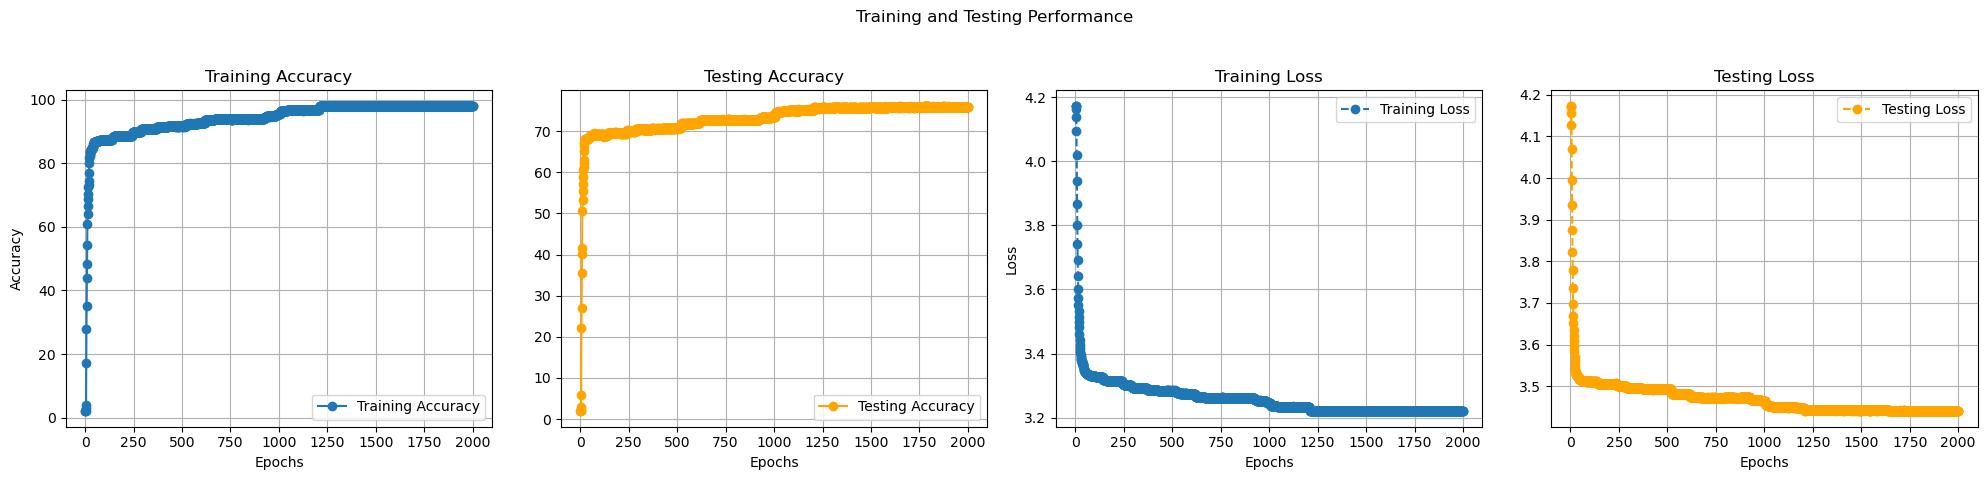

In [12]:
plot_performance(train_accuracies, test_accuracies, train_losses, test_losses, 2000)

In [14]:
input_size = 260
# Output size is 65, corresponding to the final prediction across 65 classes
output_size = 65

# Create an instance of the neural network
# ensemble_net = SingleLayerNN(input_size, output_size)
ensemble_net = MultiLayerNN(input_size, output_size)

state_dict = torch.load('./records/smriNet_best_ensemble_model_78pc.pth')

# num_input_features = best_mnet.classifier[1].in_features
# best_mnet.classifier[1] = nn.Linear(num_input_features, 65)
ensemble_net.load_state_dict(state_dict)

<All keys matched successfully>